# Notebook for model architecture

## Imports

In [2]:
#imports for the plot
import matplotlib.pyplot as plt

#imports for torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# imports for the data
import kagglehub
import pandas as pd
import os
import numpy as np
import math

C:\Users\dheen\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [3]:
# Download latest version
path = kagglehub.dataset_download("meharshanali/nvidia-stocks-data-2025")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\dheen\.cache\kagglehub\datasets\meharshanali\nvidia-stocks-data-2025\versions\1


In [4]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
df_raw = pd.read_csv(r"C:\Users\dheen\.cache\kagglehub\datasets\meharshanali\nvidia-stocks-data-2025\versions\1\NVDA.csv")
df_raw.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


In [6]:
df_raw.dtypes

Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object

In [7]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'], yearfirst=True)

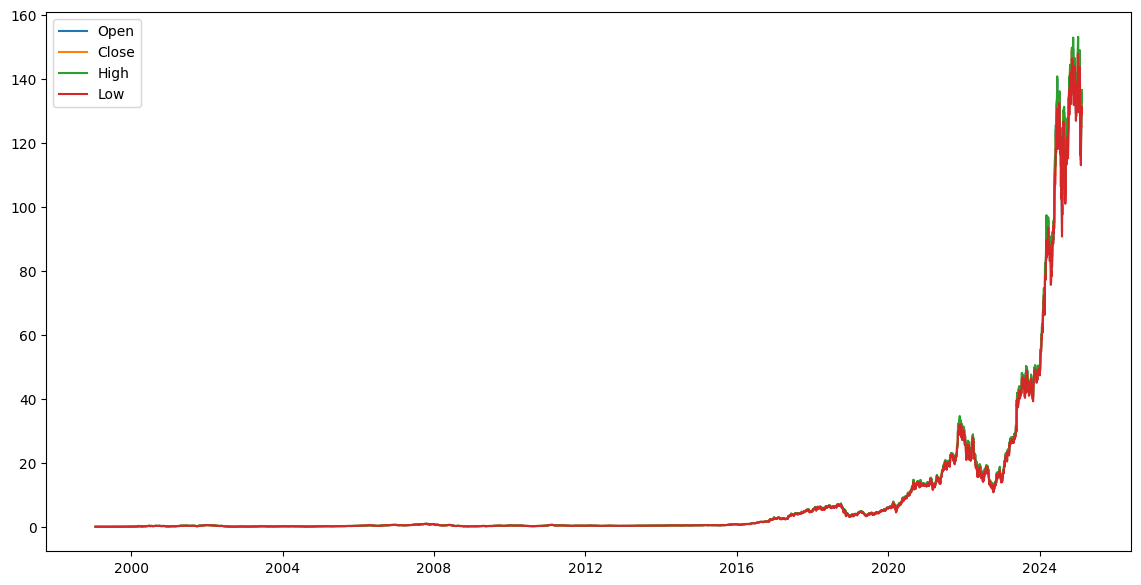

In [8]:
#create a column for the opening price of the next day
df_raw['Next_Open'] = df_raw['Open'].shift(-1)
df_raw = df_raw.dropna()

#plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_raw['Date'], df_raw['Open'], label='Open')
plt.plot(df_raw['Date'], df_raw['Close'], label='Close')
plt.plot(df_raw['Date'], df_raw['High'], label='High')
plt.plot(df_raw['Date'], df_raw['Low'], label='Low')
plt.legend()

In [9]:
#statistical analysis of the data
df_raw.describe()

,Date,Adj Close,Close,High,Low,Open,Volume,Next_Open
count,6557,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6.557000e+03,6557.000000
mean,2012-02-01 14:21:45.597071872,8.748693,8.775613,8.936696,8.598965,8.776377,5.991720e+08,8.797185
min,1999-01-22 00:00:00,0.031286,0.034115,0.035547,0.033333,0.034896,1.968000e+07,0.034896
25%,2005-07-29 00:00:00,0.257701,0.281000,0.288500,0.273333,0.280750,3.385920e+08,0.280990
50%,2012-02-01 00:00:00,0.437131,0.466000,0.472750,0.459250,0.466500,5.002710e+08,0.466667
75%,2018-08-07 00:00:00,4.592591,4.640500,4.723250,4.577500,4.628500,7.307190e+08,4.633750
max,2025-02-13 00:00:00,149.429993,149.429993,153.130005,147.820007,153.029999,9.230856e+09,153.029999
std,NaN,23.854983,23.852677,24.298241,23.368496,23.872496,4.307275e+08,23.924288


In [10]:
#create dataset/dataloader objects
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        # Select columns corresponding to the different inputs and outputs from the dataframe we just created.
        # And convert to PyTorch tensors
        x1 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Adj Close'].values, dtype=torch.float32)
        x2 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Close'].values, dtype=torch.float32)
        x3 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['High'].values, dtype=torch.float32)
        x4 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Low'].values, dtype=torch.float32)
        x5 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Open'].values, dtype=torch.float32)
        x6 = torch.tensor(self.data.iloc[idx:idx + self.window_size]['Volume'].values, dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx + self.window_size]['Next_Open'], dtype=torch.float32)
        # Assemble all input features in a single inputs tensor with 2 columns and rows for each sample in the dataset.
        inputs = torch.stack([x1, x2, x3, x4, x5, x6], dim = 0)
        return inputs, y
    

#train-test split
train_size = int(len(df_raw) * 0.75)
test_size = len(df_raw) - train_size
train_data = df_raw.iloc[:train_size, :]
test_data = df_raw.iloc[train_size:, :]
print(train_data.shape, test_data.shape)

train_dataset = StockDataset(train_data, window_size=10)
test_dataset = StockDataset(test_data, window_size=10)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



(4917, 8) (1640, 8)


In [30]:
#model
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, 
                                  batch_first = True)
        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_size, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.randn(self.num_layers, input_size, self.hidden_size).to(device)
            c0 = torch.randn(self.num_layers, input_size, self.hidden_size).to(device)
        
        out, (hn, cn) = self.lstm(input_size, (h0, c0))
        out = self.linear(out[:, -1, :])
        return out, hn, cn

In [31]:
# Define the model parameters
input_size = 10
hidden_size = 12
num_layers = 2
output_size = 1

#Create the model
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTM(
  (lstm): LSTM(10, 12, num_layers=2, batch_first=True)
  (linear): Linear(in_features=12, out_features=1, bias=True)
)


In [32]:
#display sized of inputs and targets in train_loader
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape) 
    #inputs is a tensor of size [batch_size, 6, 10] and targets is a tensor of size [batch_size]
    break

torch.Size([64, 6, 10]) torch.Size([64])


In [34]:
#training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        model.train()
        optimizer.zero_grad()
        
        h0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        c0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        
        outputs, h0, c0 = model(inputs, h0, c0)
        
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        h0 = h0.detach()
        c0 = c0.detach()

    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch: 10/100, Loss: 0.0030144297052174807
Epoch: 20/100, Loss: 0.003207771573215723
Epoch: 30/100, Loss: 0.0017804428935050964
Epoch: 40/100, Loss: 0.0017924170242622495
Epoch: 50/100, Loss: 0.0018715866608545184
Epoch: 60/100, Loss: 0.003349599428474903
Epoch: 70/100, Loss: 0.004443255253136158
Epoch: 80/100, Loss: 0.0006636452744714916
Epoch: 90/100, Loss: 0.003957310691475868
Epoch: 100/100, Loss: 0.0032092412002384663


Test loss: 0.17652098834514618


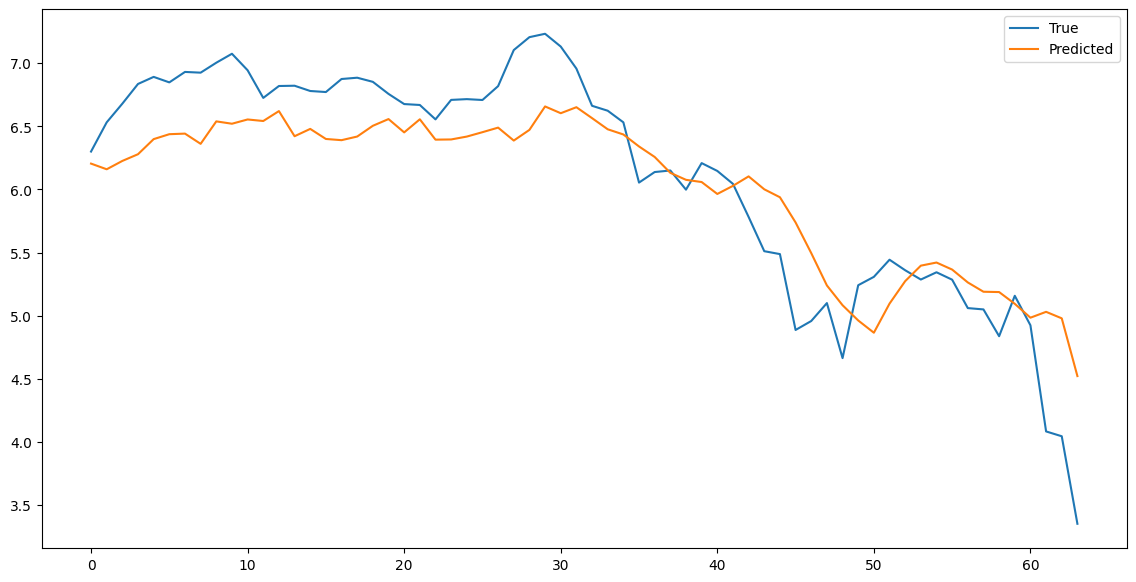

In [ ]:
#testing
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        h0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        c0 = torch.randn(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        
        outputs, h0, c0 = model(inputs, h0, c0)
        
        loss = criterion(outputs.squeeze(), targets)
        print(f'Test loss: {loss.item()}')

        outputs = outputs.squeeze().cpu().numpy()
        targets = targets.cpu().numpy()
        break

#plot the results against time
plt.figure(figsize=(14, 7))
plt.plot(range(len(outputs)), outputs, label='Predicted')
plt.plot(range(len(targets)), targets, label='Actual')
plt.legend()
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()
